In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# 随机整数 list, range from 10 to 99
rand_int = np.random.randint(10, 100, 100)
rand_int
# plot the line
plt.plot(rand_int)
# show the plot
plt.show()
# 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 随机整数列表, 范围从 10 到 99
rand_int_a = np.random.randint(10, 100, 100)
rand_int_b = np.random.randint(10, 100, 100)

# 设置窗口大小
window_size = 90

# 计算滑动平均值
smoothed_data_a = moving_average(rand_int_a, window_size)
smoothed_data_b = moving_average(rand_int_b, window_size)

# draw 2 plots, one only for raw data, one only for smoothed data
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(rand_int_a, label='raw data')
ax1.plot(rand_int_b, label='raw data')
ax1.legend()
ax2.plot(smoothed_data_a, label='smoothed data')
ax2.plot(smoothed_data_b, label='smoothed data')
ax2.legend()
plt.show()




In [ ]:
img_size = 128
img_length = 700
images1 = [np.random.randn(img_size, img_size)*0.8+0.5 for i in range(img_length)]
images2 = [np.random.randn(img_size, img_size)*0.6+0.5 for i in range(img_length)]
images3 = [np.random.randn(img_size, img_size)*0.4+0.5 for i in range(img_length)]
images4 = [np.random.randn(img_size, img_size)*0.2+0.5 for i in range(img_length)]
img_seq_list = [images1, images2, images3, images4]

In [20]:

# 定义滑动平均函数
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

def moving_average_images(img_seq_list, window_size):
    if window_size < 1 or not isinstance(window_size, int):
        raise ValueError("Window size should be a positive integer.")
    
    if len(img_seq_list) < window_size:
        raise ValueError("Window size should be smaller or equal to the number of images in the sequence.")

    averaged_images = []
    for i in range(len(img_seq_list) - window_size + 1):
        window_images = img_seq_list[i:i + window_size]
        averaged_image = np.mean(window_images, axis=0)
        averaged_images.append(averaged_image)
    
    return np.array(averaged_images)



def draw_image_means(img_seq_list, cutpoints=None):
    # draw the mean of each image only in one plot
    fig, ax = plt.subplots(1, 1)
    # Set the figure size
    fig.set_size_inches(12, 6)
    for i in range(len(img_seq_list)):
        mean = np.mean(img_seq_list[i], axis=(1, 2))
    ax.plot(mean, label='raw')
    if cutpoints is not None:
        for cutpoint in cutpoints:
            ax.axvline(x=cutpoint, color='r', linestyle='--')
    ax.legend()
    plt.show()

def draw(images, window_size=100, y=None):
    # window_size = img_length//10
    # print('image shape:', images.shape)
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

    for i in range(len(images)):
        mean = np.mean(images[i], axis=(1, 2))
        smoothed_mean = moving_average(mean, window_size)
        if y is not None:
            label = str(y[i])
            ax1.plot(mean, label='raw - '+label)
            ax2.plot(smoothed_mean, label='smooth - '+label)
        else:
            ax1.plot(mean, label='raw')
            ax2.plot(smoothed_mean, label='smooth')
    ax1.legend()
    ax2.legend()
    plt.show()


In [ ]:
draw(img_seq_list, window_size=100)

In [ ]:

draw(img_seq_list, window_size=50)

In [ ]:
draw(img_seq_list, window_size=200)

In [ ]:
draw(img_seq_list, window_size=400)

In [ ]:
diff_images = [np.diff(img, axis=0) for img in img_seq_list]

In [ ]:
draw(diff_images, window_size=10)

In [38]:
a = np.random.randint(10, 100, 10)
print(a)
b = divide_simple_segments(a, 2)
print(b)
c = np.array_split(a, 4)
print(c)

[49 76 94 57 71 58 17 62 95 37]
[2, 5, 7]
[array([49, 76, 94]), array([57, 71, 58]), array([17, 62]), array([95, 37])]


In [53]:
# n_samples: 如果为2，则差分排序的图片数量为2，均匀排序的图片数量为2，也就是一共4张大图。
import pickle
import setpath
import torch
from prepare.data import get_1C_img, get_3C_img_B
from prepare.eegdataset import GeneralEEGImageDataset


def divide_segments(x, grid_size):
    delta_x = np.sum(np.abs(np.diff(x, axis=0)), axis=(1, 2))
    sorted_diff = sorted(enumerate(delta_x), key=lambda x: x[1], reverse=True)
    sorted_indexes = [i for i, diff in sorted_diff][:grid_size*grid_size-1]
    sorted_indexes.sort()
    return sorted_indexes

def divide_simple_segments(x, grid_size):
    split_x = np.array_split(x, grid_size*grid_size)
    print(len(split_x))
    # 计算每个子数组的结束索引
    indexes = [np.where(x == subarray[-1])[0][0] for subarray in split_x[:-1]]
    # 返回分割点的下标索引
    return indexes


class C_GeneralEEGImageDataset(GeneralEEGImageDataset):
    def __init__(self, path, n_channels=3, grid_size=8, n_samples=2):
        super().__init__(path, n_channels, grid_size)
        self.n_samples = n_samples

    def __getitem__(self, idx):
        filepath = self.filepaths[idx]

        with open(filepath, 'rb') as f:
            x = pickle.load(f)  # [t, w, h]
            x = x[:, 2:-2, 2:-2]
            diff_x = np.diff(x, axis=0)
            ddiff_x = np.diff(diff_x, axis=0)
            # draw(x, window_size=10)
            # draw(diff_x, window_size=10)
            # draw(ddiff_x, window_size=10)
            # #挑选图片
            # c_segments = divide_segments(x, self.grid_size)
            # # 简单划分，均匀划分，效果不明显
            # c_segments = divide_simple_segments(x, self.grid_size)
            # # 直接用差分图片
            # segments = divide_segments(diff_x, self.grid_size)
            # c_segments = divide_segments(ddiff_x, self.grid_size)
            # x_list = []

            # if self.n_channels == 1:
            #     for i in range(self.n_samples):
            #         x_list.append(get_1C_img(segments, self.grid_size))
            #         x_list.append(get_1C_img(c_segments, self.grid_size))
            # elif self.n_channels == 3:
            #     for i in range(self.n_samples):
            #         x_list.append(get_3C_img_B(segments, self.grid_size))
            #         x_list.append(get_3C_img_B(c_segments, self.grid_size))

            y = int(pickle.load(f))
            assert 0 <= y <= 39
            y = torch.tensor(y, dtype=torch.long)
        
        return x, diff_x, ddiff_x, y

In [3]:
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from prepare.eegdataset import MySubset
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
data_path = '/data0/tianjunchao/dataset/CVPR2021-02785/data/img_pkl/32x32'
n_samples = 1
dataset = C_GeneralEEGImageDataset(path=data_path, n_channels=1, grid_size=8, n_samples=n_samples)
scale = 2
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)

In [4]:
for i, (x, dx, ddx, y) in enumerate(dataloader):
    x = x.numpy()
    dx = dx.numpy()
    ddx = ddx.numpy()
    y = y.numpy()
    average_x = [moving_average_images(x[i], window_size=100) for i in range(len(x))]
    draw(x, window_size=300, y=y)
    if i > 3:
        break

NameError: name 'moving_average_images' is not defined

In [5]:
average_x = [moving_average_images(x[i], window_size=100) for i in range(len(x))]
draw(x, window_size=10, y=y)
draw(average_x, window_size=10, y=y)

NameError: name 'moving_average_images' is not defined

16


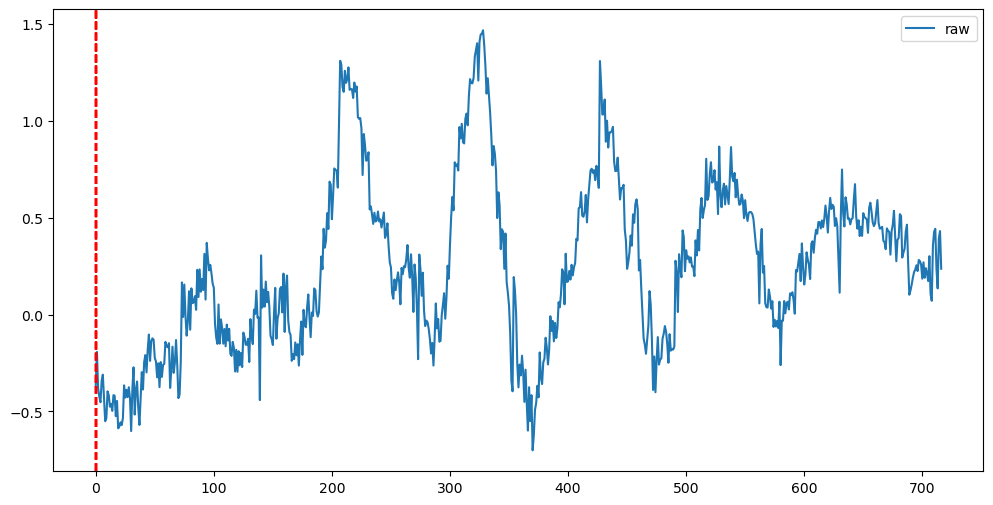

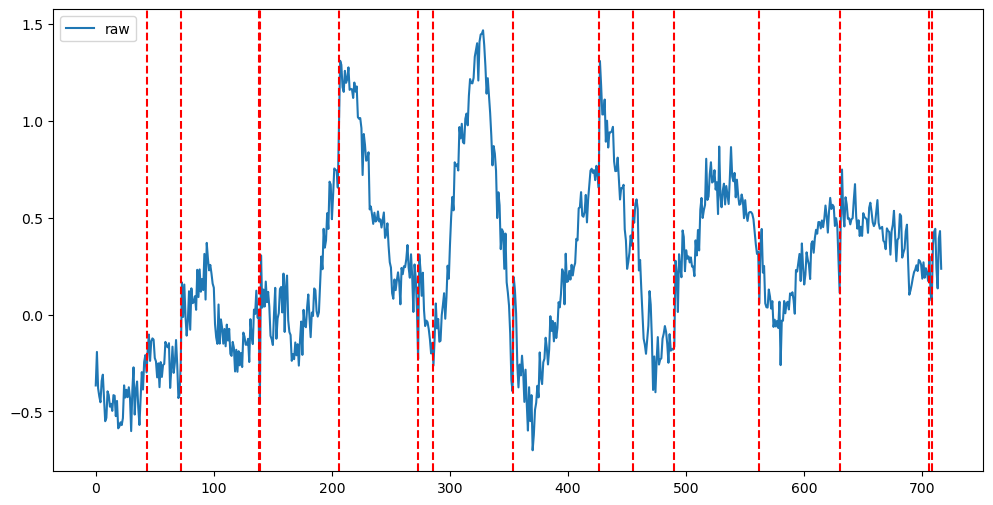

In [54]:
sim_cutpoints = divide_simple_segments(x[0], 4)
dif_cutpoints = divide_segments(x[0], 4)

draw_image_means([x[0]],cutpoints=sim_cutpoints)
draw_image_means([x[0]],cutpoints=dif_cutpoints)

In [44]:
sim_cutpoints

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [48]:
x[0].shape
split_x = np.array_split(x[0], 4)
print(len(split_x))
# 计算每个子数组的结束索引
# indexes = [np.where(x == subarray[-1])[0][0] for subarray in split_x[:-1]]
# # 返回分割点的下标索引
# return indexes

4
